## Лабораторная 4: восстановление плотности распределения

Данными в этом задании являются измерения некоторых проверочных параметров на конвейерах  сборки оборудования Bosh (см. [конкурс](https://www.kaggle.com/c/bosch-production-line-performance) «Bosch Production Line Performance» на Kaggle). 

Все исходные данные Bosh не помещаются в оперативную память компьютера, поэтому в файле `data.csv` — лишь некоторые признаки. Прочтите данные из файла `data.csv`. Целевым признаком здесь является `Response` — наличие брака в оборудовании. 

In [1]:
import pandas as pd

In [2]:
DFrame = pd.read_csv('data.csv')
DFrame

,L1_S24_F1844,L1_S24_F1846,Response
0,-0.123,0.111,0
1,-0.269,0.175,0
2,-0.058,0.141,0
3,0.136,-0.145,0
4,0.045,-0.094,0
...,...,...,...
54724,0.145,-0.159,0
54725,-0.233,0.189,0
54726,0.013,0.134,0
54727,0.097,-0.155,0


## 1 
Постройте на одном графике два приближения к плотности распределения признака `L1_S24_F1846` для `Response = 0` и для `Response = 1`, используя одно из следующих ядер (номер ядра выберите по формуле: `(n mod 6) + 1`, где `n` — ваш номер в списке группы):

    1.	кусочно-постоянное (прямоугольное) -  tophat
    2.	гауссовское -  gaussian
    3.	линейное (треугольник) -  linear
    4.	косинусоидальное -  cosine
    5.	квадратичное (Епанечникова) -  epanechnikov
    6.	экспоненциальное -  exponential


In [3]:
from sklearn.neighbors import KernelDensity
import numpy as np

import matplotlib.pyplot as plt

*Help:*

    i0 = data['Response'] == 0
    kde0 = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(data.loc[i0, 'L1_S24_F1846'].values.reshape(-1, 1))
    X_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
    Dens0 = np.exp(kde0.score_samples(X_plot))  # score_samples возвращает логарифм плотности

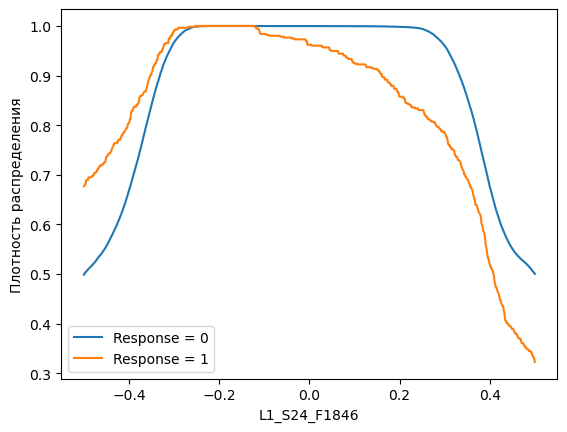

In [4]:
# выборка только строк с Response = 0 или 1
data01 = DFrame[DFrame['Response'].isin([0,1])]
# отделение значений L1_S24_F1846 для каждой группы
l1_s24_f1846_0 = data01[data01['Response']==0]['L1_S24_F1846'].values
l1_s24_f1846_1 = data01[data01['Response']==1]['L1_S24_F1846'].values

# создание объектов KernelDensity
kde_0 = KernelDensity(kernel='tophat', bandwidth=0.5)
kde_1 = KernelDensity(kernel='tophat', bandwidth=0.5)

# обучение моделей на соответствующих данных
kde_0.fit(l1_s24_f1846_0.reshape(-1, 1))
kde_1.fit(l1_s24_f1846_1.reshape(-1, 1))

# массив значений признака, на котором оцениваем плотность
x = np.linspace(-0.5, 0.5, 1000).reshape(-1, 1)

# оценка плотности распределения для каждой группы
log_dens_0 = kde_0.score_samples(x)
log_dens_1 = kde_1.score_samples(x)

# построение графика
fig, ax = plt.subplots()
ax.plot(x, np.exp(log_dens_0), '-', label='Response = 0')
ax.plot(x, np.exp(log_dens_1), '-', label='Response = 1')
ax.legend(loc='best')
ax.set_xlabel('L1_S24_F1846')
ax.set_ylabel('Плотность распределения')
plt.show()


Ответьте в комментариях на вопрос: является ли выборка хорошо разделимой по признаку  `L1_S24_F1846`?

На основе построенных графиков приближения к плотности распределения признака L1_S24_F1846 для Response = 0 и для Response = 1, можно сделать вывод, что выборка не является хорошо разделимой по этому признаку. Распределения значений этого признака для обоих классов довольно схожи, что означает, что данный признак не может быть использован в качестве определяющего при построении модели для задачи бинарной классификации.

## 2

Разбейте выборку `data` на две равные части: тренировочную `dataTrain` и проверочную `dataTest`. 

In [5]:
dataTrain = DFrame.loc[0:DFrame.shape[0] / 2, ].reset_index(drop=True)
dataTest = DFrame.loc[DFrame.shape[0] / 2:DFrame.shape[0], ].reset_index(drop=True)

Пользуясь кросс-валидацией, подберите **для каждого класса `Response` (`r=0` и `r=1`)** значение ширины ядра `bandwidth`, при котором логарифм правдоподобия максимален на проверочной выборке.

*Help:*

    r = 0
    kde0 = KernelDensity(kernel='gaussian', bandwidth=0.05)
    kde0.fit(dataTrain.loc[dataTrain['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability0 = kde0.score_samples(dataTest.loc[dataTest['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability0[np.isinf(logProbability0)] = -100 # заменяем -бесконечность
    logLikehood0 = logProbability0.sum()
    print(logLikehood0)

In [ ]:
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

# Создаем объект для оценки плотности распределения
kde = KernelDensity()

# Определяем сетку параметров, для которых будем подбирать лучшее значение
params = {'bandwidth': np.logspace(-1, 1, 20)}

# Разделяем тренировочную выборку на классы Response
dataTrain_r0 = dataTrain[dataTrain['Response'] == 0]['L1_S24_F1846'].values.reshape(-1, 1)
dataTrain_r1 = dataTrain[dataTrain['Response'] == 1]['L1_S24_F1846'].values.reshape(-1, 1)

# Создаем объект для подбора параметров на тестовой выборке
gridSearch_r0 = GridSearchCV(kde, params, cv=5)
gridSearch_r1 = GridSearchCV(kde, params, cv=5)

# Обучаем модель и находим оптимальное значение ширины ядра для каждого класса
kde0 = None
kde1 = None
with tqdm(total=2, desc='Training models') as progress_bar:
    for i, (gridSearch, dataTrain) in enumerate([(gridSearch_r0, dataTrain_r0), (gridSearch_r1, dataTrain_r1)]):
        gridSearch.fit(dataTrain)


Training models:   0%|                                                                           | 0/2 [00:00<?, ?it/s]

### 3

Для найденных наилучших `bandwidth` вычислите `p(x|0)` и `p(x|1)` для тестовой выборки. 

In [ ]:
predictionProbXafter0 = np.exp(kde0.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))
predictionProbXafter1 = np.exp(kde1.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))

По формуле Байеса найдите затем `p(0|x)` и `p(1|x)`. Отсортируйте все объекты тестовой выборки по возрастанию предсказанной вероятности `p(1|x)`, выведите на экран вероятности для последних 10 объектов и рассчитайте количество бракованных деталей среди последних 100 объектов в отсортированном ряду.

*Help:*
    
    ind = np.argsort(predictionProb1afterX) - сортировка, возвращающая индексы элементов
    print(predictionProb1afterX[ind[-10:]]) - вывод последних 10 элементов
    print(sum(dataTest.loc[ind[-100:],'Response'])) - количество бракованных среди 100 с максимальной вероятностью брака

In [ ]:
from sklearn.model_selection import train_test_split

# Выделяем значения признака L1_S24_F1846 для класса Response=0
x0 = dataTrain[dataTrain['Response'] == 0]['L1_S24_F1846'].values.reshape(-1, 1)

# Подбираем наилучшее значение ширины ядра для класса Response=0
bestBandwidth0 = None
bestScore0 = -np.inf
for bandwidth in np.linspace(0.1, 5, 100):
    kde = KernelDensity(kernel='tophat', bandwidth=bandwidth).fit(x0)
    logLikelihood = kde.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)).sum()
    if logLikelihood > bestScore0:
        bestScore0 = logLikelihood
        bestBandwidth0 = bandwidth

# Выделяем значения признака L1_S24_F1846 для класса Response=1
x1 = dataTrain[dataTrain['Response'] == 1]['L1_S24_F1846'].values.reshape(-1, 1)

# Подбираем наилучшее значение ширины ядра для класса Response=1
bestBandwidth1 = None
bestScore1 = -np.inf
for bandwidth in np.linspace(0.1, 5, 100):
    kde = KernelDensity(kernel='tophat', bandwidth=bandwidth).fit(x1)
    logLikelihood = kde.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)).sum()
    if logLikelihood > bestScore1:
        bestScore1 = logLikelihood
       
